# MLofi: Model training

## Setup

In [2]:
model_type = "gru"  # possible values ["srnn", "lstm", "gru", "cnn"]

### Hyperparameters

This parameter configures the length of the sequences used for the prediction. The sequences are fixed-length due to how recurrent links are implemented.

This parameter is particularly interesting, as it determines how much data in the past can the network access.

Due to the nature of the parameter, it also represents the length of the seed used to generate new songs.

In [1]:
sequence_length = 30

### Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Dropout, Concatenate, Activation
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Conv1D, MaxPool1D, GlobalMaxPool1D

from music21 import *

import numpy as np

import os
import re

### Mount Google Drive to access the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def create_path(relative_path):
  return f'/content/drive/My Drive/MLofi/{relative_path}'

In [6]:
dataset_directory = create_path('datasets/lofi-hip-hop-midi')
path_to_unique_notes = create_path('output/data/unique_notes.txt')

## Training

### Loading the datasets

The following datasets were used:
- [Lo-Fi Hip Hop MIDIs](https://www.kaggle.com/zakarii/lofi-hip-hop-midi/metadata)
  by *zakarii*
- [Lo-fi samples](https://github.com/nmtremblay/lofi-samples) by *nmtremblay*

#### Navigating and reading the songs

In [7]:
def read_song(song):
  song_elements = []

  for element in song.recurse():   
    if isinstance(element, note.Note):
      song_elements.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      song_elements.append('.'.join(str(n) for n in element.normalOrder))
    elif isinstance(element, note.Rest):
      # song_elements.append(str(element.fullName))
      pass

  return song_elements

In [8]:
# The `songs` list holds the notes and chords for every song in the dataset
songs = []

for subdirs, dirs, files in os.walk(dataset_directory):
  for file in files:
    current_song_path = os.path.join(subdirs, file)
    current_song_parse = converter.parse(current_song_path)
           
    songs.append(read_song(current_song_parse))

#### Processing the datasets

##### Flattening the songs

The song elements (notes, chords, and rests) from the songs are flattened into a single
list.

In [9]:
def flatten_songs(songs):
  elements = []

  for song in songs:
    # Paddings signal a song's beginning
    # elements.append('Padding')

    for element in song:
        elements.append(element)

  return elements

In [10]:
all_notes = flatten_songs(songs)
unique_notes = list(set(all_notes))
note_to_index = dict([(note, index) for index, note in enumerate(unique_notes)])
unique_note_count = len(unique_notes)
unique_note_count

249

##### Creating the note, chord and rest collection

In [11]:
with open(path_to_unique_notes, "w") as f:
  f.write(str("\n".join(unique_notes)))

##### Transforming the datasets into sequences

In [12]:
sequences = []        # a sequence is the input to the network
following_notes = []  # the corresponding notes we're trying to predict

for i in range(sequence_length, len(all_notes)):
    sequence = all_notes[i - sequence_length : i]
    result = all_notes[i]
    
    sequences.append([note_to_index[note] for note in sequence])
    following_notes.append(note_to_index[result])

if model_type == 'cnn':
  X = np.array(sequences)
  y = keras.utils.to_categorical(following_notes, num_classes=unique_note_count)
else:
  for i, xs in enumerate(sequences):
    sequences[i] = [[note] for note in sequences[i]]
  sequences = np.array(sequences)
  X = keras.utils.to_categorical(sequences, num_classes=unique_note_count)
  y = keras.utils.to_categorical(following_notes, num_classes=unique_note_count)

### Defining the model

In [23]:
if model_type == "lstm":
  input = Input(shape=(sequence_length, unique_note_count))
  hidden_1 = Dropout(0.3)(LSTM(700, return_sequences=True, recurrent_dropout=0.2)(input))
  hidden_2 = Dropout(0.3)(LSTM(700, return_sequences=True, recurrent_dropout=0.2)(Concatenate()([input, hidden_1])))
  hidden_3 = Dropout(0.3)(LSTM(700, return_sequences=True, recurrent_dropout=0.2)(Concatenate()([input, hidden_2])))
  hidden_4 = LSTM(700, recurrent_dropout=0.3)(Concatenate()([hidden_1, hidden_2, hidden_3]))
  dense_1 = Dense(unique_note_count)(hidden_4)
  output = Activation('softmax')(dense_1)
elif model_type == "gru":
  input = Input(shape=(sequence_length, unique_note_count))
  hidden_1 = Dropout(0.3)(GRU(700, return_sequences=True, recurrent_dropout=0.3)(input))
  hidden_2 = Dropout(0.3)(GRU(700, return_sequences=True, recurrent_dropout=0.3)(Concatenate()([input, hidden_1])))
  hidden_3 = Dropout(0.3)(GRU(700, return_sequences=True, recurrent_dropout=0.3)(Concatenate()([input, hidden_2])))
  hidden_4 = GRU(700, recurrent_dropout=0.3)(Concatenate()([hidden_1, hidden_2, hidden_3]))
  dense_1 = Dense(unique_note_count)(hidden_4)
  output = Activation('softmax')(dense_1)
elif model_type == "srnn":
  input = Input(shape=(sequence_length, unique_note_count))
  hidden_1 = Dropout(0.3)(SimpleRNN(700, return_sequences=True)(input))
  hidden_2 = Dropout(0.3)(SimpleRNN(700, return_sequences=True)(Concatenate()([input, hidden_1])))
  hidden_3 = Dropout(0.3)(SimpleRNN(700, return_sequences=True)(Concatenate()([input, hidden_2])))
  hidden_4 = SimpleRNN(700)(Concatenate()([hidden_1, hidden_2, hidden_3]))
  dense_1 = Dense(unique_note_count)(hidden_4)
  output = Activation('softmax')(dense_1)
elif model_type == "cnn":
  input = Input(shape=(sequence_length,))
  embedding = Embedding(unique_note_count, 100, input_length=sequence_length, trainable=True)(input)
  conv_1 = Conv1D(64, 3, padding='causal', activation='relu')(embedding)
  pool_1 = MaxPool1D(2)(conv_1)
  conv_2 = Conv1D(128, 3, padding='causal', activation='relu', dilation_rate=2)(Dropout(0.2)(pool_1))
  pool_2 = MaxPool1D(2)(conv_2)
  conv_3 = Conv1D(256, 3, padding='causal', activation='relu', dilation_rate=4)(Dropout(0.2)(pool_2))
  pool_3 = GlobalMaxPool1D()(conv_3)
  dense_1 = Dense(256)(pool_3)
  dense_2 = Dense(unique_note_count)(dense_1)
  output = Activation('softmax')(dense_2)

model = keras.Model(inputs=input, outputs=output, name=f'MLofi-{model_type}')

In [14]:
model.summary()

Model: "MLofi-gru"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 249)]    0           []                               
                                                                                                  
 gru (GRU)                      (None, 30, 700)      1997100     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 700)      0           ['gru[0][0]']                    
                                                                                                  
 concatenate (Concatenate)      (None, 30, 949)      0           ['input_1[0][0]',                
                                                                  'dropout[0][0]']        

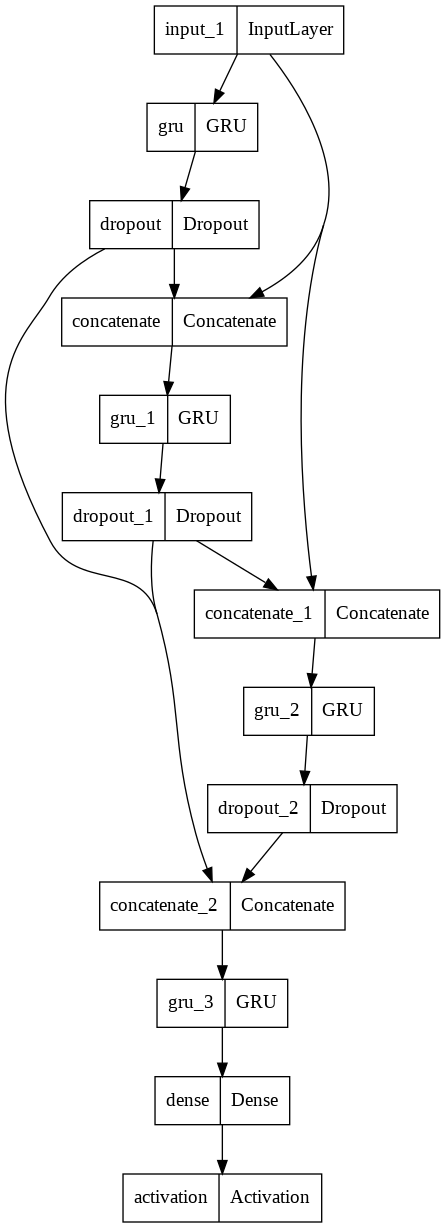

In [15]:
keras.utils.plot_model(model, "model.png")

### Compiling and training the model

In [24]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [21]:
filepath = create_path("weights/weights.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [25]:
epochs_map = {'srnn': 50, 'lstm': 18, 'gru': 18, 'cnn': 50}
history = model.fit(X, y, epochs=epochs_map[model_type], batch_size=64, callbacks=callbacks_list)

Epoch 1/18
34/34 [==============================] - ETA: 0s - loss: 4.7993 - accuracy: 0.0661
Epoch 00001: loss improved from inf to 4.79930, saving model to /content/drive/My Drive/MLofi/weights/weights.hdf5
34/34 [==============================] - 42s 990ms/step - loss: 4.7993 - accuracy: 0.0661
Epoch 2/18
34/34 [==============================] - ETA: 0s - loss: 4.0635 - accuracy: 0.1161
Epoch 00002: loss improved from 4.79930 to 4.06350, saving model to /content/drive/My Drive/MLofi/weights/weights.hdf5
34/34 [==============================] - 34s 1s/step - loss: 4.0635 - accuracy: 0.1161
Epoch 3/18
34/34 [==============================] - ETA: 0s - loss: 3.6434 - accuracy: 0.1483
Epoch 00003: loss improved from 4.06350 to 3.64336, saving model to /content/drive/My Drive/MLofi/weights/weights.hdf5
34/34 [==============================] - 34s 1s/step - loss: 3.6434 - accuracy: 0.1483
Epoch 4/18
34/34 [==============================] - ETA: 0s - loss: 3.3102 - accuracy: 0.1780
Epoch 0

In [26]:
keras.models.save_model(model, filepath=create_path(f'models/{model_type}.hdf5'))